In [1]:
%matplotlib inline
%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#from matplotlib import cm
import math
from scipy.optimize import minimize

In [2]:
# Input Values

xySensor  = np.array([[ 0.1,-0.9,0.2, 0.8,-0.6, 0.3,  0.5,-0.5,-0.01,-0.9,
                         -1,  1,  1,  -1.0],
                      [0.05, 0.3,0.4,-0.3, 0.3,-0.2,-0.84,0.85,-0.76,-0.9, 
                          1, -1,  1, -0.38]])
#xSensor   = xySensor[0,:]
#ySensor   = xySensor[1,:]
#xySensor  = np.transpose(xySensor)
outSensor = np.array([3.39382006,3.2073034,3.39965035,3.68810201,2.96941623,2.99495501,3.94274928,2.7968011,3.34929734,3.91296165,
                      3.1387899881135106, 4.209940485369121, 3.696383911273774, 3.1915742047594664])

discretization = 100
xPred =  np.linspace(-1, 1, discretization)
yPred =  np.linspace(-1, 1, discretization)
xPredMesh, yPredMesh = np.meshgrid(xPred,yPred)
xyPred = (np.array([xPredMesh.flatten(),yPredMesh.flatten()]))


MEAN = np.mean(outSensor)
noise = 1e-5
tau = 0.5
l = 0.2

In [3]:
# Function: Kernel 

def sqexp(x, xp, tauin, lin):
    """Squared exponential kernel (1 dimensional)
    
    Inputs
    ------
    x : (N), array of multiple inputs
    xp: float
    
    Returns
    -------
    cov (N,) -- Covariance between each input at *x* and the function values at *x*
    """
    cov = tauin**2 * np.exp(-1/2 * (x - xp)**2 / lin**2)
    return cov

def sqexp2d(x, xp, tauin, lin):
    """Squared exponential kernel (2 dimensional) """  
    xX   = x[0,:]
    xY   = x[1,:]
    xpX  = xp[0]
    xpY  = xp[1]
    tauX = tauin
    tauY = 1 # tauY=1 bc I only want one tau to tune
    sqexpX = sqexp(xX, xpX, tauX, lin)
    sqexpY = sqexp(xY, xpY, tauY, lin) 
    cov = sqexpX*sqexpY
    return cov

In [4]:
# Function: Covariance 

def build_covariance(x, xp,tauin, lin, kern):
    """Build a covariance matrix
    
    Inputs
    -------
    x: (N) array of inputs
    xp: (M) array of inptus
    kern: a function mapping inputs to covariance
    
    Outputs
    -------
    cov: (N, M) covariance matrix
    """
    out = np.zeros((x.shape[1], xp.shape[1]))
    for jj in range(xp.shape[1]):
        out[:, jj] = kern(x, xp[:,jj], tauin, lin)
    return out

In [5]:
# Function: GPR

def gpr(xtrain, ytrain, xpred, noise_var, mean_func, kernel):
    """Gaussian process regression Algorithm

    Inputs
    -------
    xtrain: (N, ) training inputs
    ytrain: (N, ) training outputs
    xpred:  (M, ) locations at which to make predictions
    noise_var: (N, ) noise at every training output
    mean_func: function to compute the prior mean
    kernel: covariance kernel
    
    Returns
    -------
    pred_mean : (M, ) predicted mean at prediction points
    pred_cov : (M, M) predicted covariance at the prediction points
    --
    """
    #xtrain  = np.transpose(xtrain)
    cov = build_covariance(xtrain, xtrain, tau, l, kernel)
    u, s, v = np.linalg.svd(cov)
    sqrtcov = np.dot(u, np.sqrt(np.diag(s)))

    noiseArray=(np.ones(np.size(xtrain[1,:])))*noise_var
    
    # pseudoinverse is better conditioned
    invcov = np.linalg.pinv(cov + np.diag(noiseArray))
    
    vec_pred = build_covariance(xpred, xtrain, tau, l, kernel)
    
    pred_mean = MEAN + np.dot(vec_pred, np.dot(invcov, ytrain - MEAN))
    cov_predict_pre = build_covariance(xpred, xpred, tau, l, kernel)
    cov_predict_up = np.dot(vec_pred, np.dot(invcov, vec_pred.T))
    pred_cov = cov_predict_pre - cov_predict_up
    #print(cov_predict_pre)
    
    return pred_mean, pred_cov

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
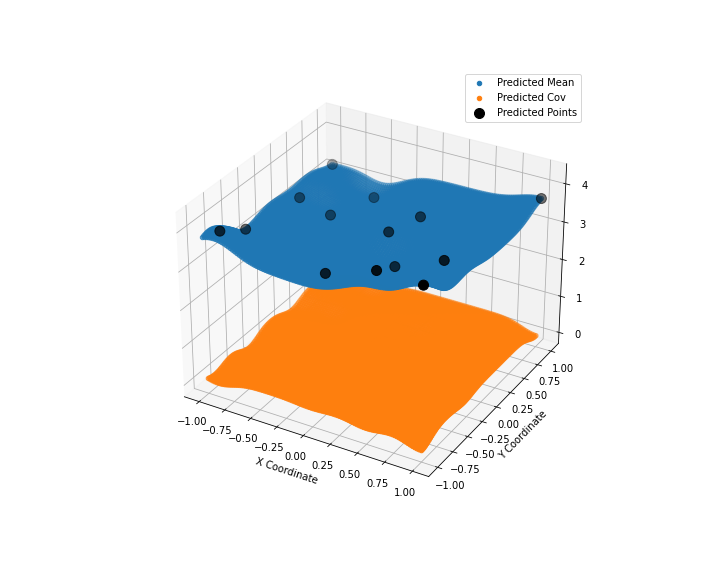

In [6]:
# GPR Results

#l=1
#noise=1e-5

meanPred, covPred = gpr(xySensor, outSensor, xyPred, noise, MEAN, sqexp2d)

xPredMeshF, yPredMeshF = xPredMesh.flatten(),yPredMesh.flatten()
plt.figure(num='mean and cov',figsize=(10,8))
fig1 = plt.axes(projection='3d')
fig1.scatter3D(xPredMeshF,yPredMeshF,meanPred,cmap='winter',label='Predicted Mean')
fig1.scatter3D(xPredMeshF,yPredMeshF,np.diag(covPred),cmap='winter',label='Predicted Cov')
fig1.scatter3D(xySensor[0,:], xySensor[1,:], outSensor, c='k',label="Predicted Points", s=100)
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(-1, 1.25, step=0.25))  # Set label locations.
plt.yticks(np.arange(-1, 1.25, step=0.25))  # Set label locations.
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
fig1.set_zlabel("Sensor Output")
plt.legend()
plt.show()

In [13]:
# Function: ± 2 Sigma Pred Computation

def twoSigma(inputMean, inputCov):
    varPred    = np.array(np.diag(inputCov))
#print((varPred))
# varPred[varPred<0]=0 
# A negative covariance means that the variables are inversely related, or that they move in opposite directions.
# cov(x,x) not negative
    stdDevPred = np.sqrt(varPred)
#print((stdDevPred))

    P2SigmaPred = inputMean + (2*stdDevPred)
    N2SigmaPred = inputMean - (2*stdDevPred)

    plt.figure(num='Pred Mean  ± 2 Sigma Pred Computation',figsize=(10,8))
    ax = plt.axes(projection='3d')
    ax.scatter3D(xPredMeshF,yPredMeshF,meanPred,cmap='winter',label='Predicted Mean')
    ax.scatter3D(xPredMeshF,yPredMeshF,P2SigmaPred,cmap='plasma',label='Predicted Mean + 2 Sigma')
    ax.scatter3D(xPredMeshF,yPredMeshF,N2SigmaPred,cmap='plasma',label='Predicted Mean - 2 Sigma')
    #ax.plot_trisurf(xPredMeshF, yPredMeshF, stdDevPred,cmap='jet',label="Predicted Points")
    #ax.scatter3D(xySensor[0,:], xySensor[1,:], outSensor, c='k',label="Predicted Points", s=100)
    locs, labels = plt.xticks()  # Get the current locations and labels.
    plt.xticks(np.arange(-1, 1.25, step=0.25))  # Set label locations.
    plt.yticks(np.arange(-1, 1.25, step=0.25))  # Set label locations.
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    ax.set_zlabel("Sensor Output")
    plt.legend()
    plt.show(ax)
    
    return(varPred,stdDevPred,P2SigmaPred,N2SigmaPred)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
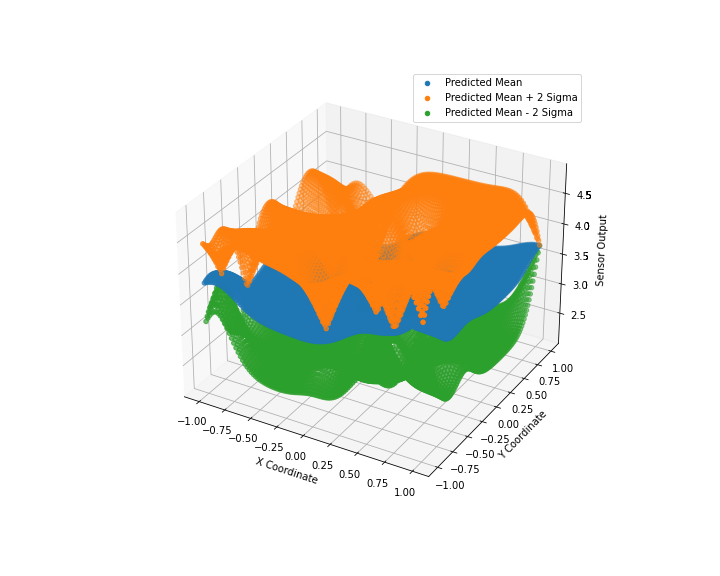

In [14]:
# ± 2 Sigma Pred Computation
varMeanPred,stdDevMeanPred, P2SigmaMeanPred, N2SigmaMeanPred = twoSigma(meanPred, covPred)
#print(stdDevMeanPred)
#print(P2SigmaMeanPred)
#print(N2SigmaMeanPred)

In [ ]:
# STD Pred Plot

plt.figure(num='Pred Mean STD',figsize=(10,8))
fig3 = plt.axes(projection='3d')
fig3.scatter3D(xPredMeshF,yPredMeshF,meanPred,cmap='winter',label='Predicted Mean')
fig3.scatter3D(xPredMeshF,yPredMeshF,P2SigmaMeanPred,cmap='cool',label='Predicted Mean + 2 Sigma')
fig3.scatter3D(xPredMeshF,yPredMeshF,N2SigmaMeanPred,cmap='cool',label='Predicted Mean - 2 Sigma')
fig3.scatter3D(xPredMeshF, yPredMeshF, stdDevMeanPred,cmap='magma',label="Predicted Points")
#fig1.scatter3D(xySensor[0,:], xySensor[1,:], outSensor, c='k',label="Predicted Points", s=100)
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(-1, 1.25, step=0.25))  # Set label locations.
plt.yticks(np.arange(-1, 1.25, step=0.25))  # Set label locations.
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()

In [ ]:
# Function: HyperParameters

def likelihood(x):
    tau_l, l_l, noise_l = x
    noiseArray=(np.ones(np.size(xySensor[0,:])))*noise_l
    cov = build_covariance(xySensor, xySensor, tau_l, l_l, sqexp2d)
    invcov = np.linalg.pinv(cov + np.diag(noiseArray))

    #marg_l = -1 * (-1 / 2 * np.dot((outSensor.T-3.37), 
    #                               np.dot(invcov,outSensor-3.37)) - 1 / 2 * np.log(
    #    np.linalg.det(cov + np.diag(noiseArray))) - 10 / 2 * np.log(np.pi * 2))
    
    likelihoodOut = 0.5 * np.dot((outSensor.T-MEAN), np.dot(invcov, (outSensor-MEAN)))\
           + 0.5 * np.log(np.linalg.det(cov + np.diag(noiseArray)))\
           + 0.5 * np.size(xySensor[1,:]) * np.log(2*np.pi)
        
    return likelihoodOut

In [ ]:
# HyperParameters Results

noise = 1e-5
tau = 0.5
l = 0.2

xInit=np.array([tau, l, noise])
#marg_out = likelihood(xInit)
#print(marg_out)
bounds = [(1e-15,None),(1e-15,None),(1e-15,None)]
minOut = minimize(likelihood, xInit, bounds=bounds, method='nelder-mead')
#print(minOut)

#noise_vect = np.zeros((np.size(xySensor[:,1])))
minOutX = np.array(minOut.x)
tau = minOutX[0]
#print(tau)
l = minOutX[1]
#print(l)
noise = minOutX[2]
#print(noise)
meanPred, covPred = gpr(xySensor, outSensor, xyPred, noise, MEAN, sqexp2d)
#print(meanPred)
#print(covPred)

fig = plt.figure('Hyperparameter Pred Mean',figsize=(10,8))
fig4 = plt.axes(projection='3d')
fig4.scatter3D(xPredMeshF,yPredMeshF,meanPred,cmap='winter',label="Predicted Mean")
fig4.scatter3D(xPredMeshF,yPredMeshF,np.diag(covPred),cmap='winter',label="Predicted Cov")
fig4.scatter3D(xySensor[0,:], xySensor[1,:], outSensor, c='k',label="Predicted Points", s=100)
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(-1, 1.25, step=0.25))  # Set label locations.
plt.yticks(np.arange(-1, 1.25, step=0.25))  # Set label locations.
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()

In [ ]:
print(minOutX)

In [ ]:
# Hyperparameter ± 2 Sigma Pred Computation
varPred, stdDevMeanPred, P2SigmaMeanPred, N2SigmaMeanPred = twoSigma(meanPred, covPred)


In [ ]:
# Hyperparameter STD Pred Plot

plt.figure(num='Pred Mean STD',figsize=(10,8))
fig5 = plt.axes(projection='3d')
fig5.scatter3D(xPredMeshF,yPredMeshF,meanPred,cmap='winter',label='Predicted Mean')
#fig3.plot_trisurf(xPredMeshF,yPredMeshF,P2SigmaMeanPred,cmap='cool',label='Predicted Mean + 2 Sigma')
#fig3.plot_trisurf(xPredMeshF,yPredMeshF,N2SigmaMeanPred,cmap='cool',label='Predicted Mean - 2 Sigma')
fig5.scatter3D(xPredMeshF, yPredMeshF, stdDevMeanPred,cmap='magma',label="Predicted Points")
#fig1.scatter3D(xySensor[0,:], xySensor[1,:], outSensor, c='k',label="Predicted Points", s=100)
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(-1, 1.25, step=0.25))  # Set label locations.
plt.yticks(np.arange(-1, 1.25, step=0.25))  # Set label locations.
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()

In [ ]:
# Function : Finding indices of the peaks of a matrix

def findPeaks(inputMatrix):
    paddedMatrix = np.pad(inputMatrix,(1),'constant',constant_values=0)
    length1      = len(inputMatrix[0])
    length2      = len(inputMatrix[1])
    peakInd      = np.zeros((length1,length2))
    #print(length1)
    #print(length2)
    for xi in range(0,length1):
        for yi in range(0,length2):
            #print(xi)
            if paddedMatrix[xi+1,yi+1] > paddedMatrix[   xi , yi   ] and \
               paddedMatrix[xi+1,yi+1] > paddedMatrix[   xi , yi+1 ] and \
               paddedMatrix[xi+1,yi+1] > paddedMatrix[   xi , yi+2 ] and \
               paddedMatrix[xi+1,yi+1] > paddedMatrix[ xi+1 , yi   ] and \
               paddedMatrix[xi+1,yi+1] > paddedMatrix[ xi+1 , yi+2 ] and \
               paddedMatrix[xi+1,yi+1] > paddedMatrix[ xi+2 , yi   ] and \
               paddedMatrix[xi+1,yi+1] > paddedMatrix[ xi+2 , yi+1 ] and \
               paddedMatrix[xi+1,yi+1] > paddedMatrix[ xi+2 , yi+2 ]:
               
                peakInd[xi,yi] = 1
        
    return peakInd     

In [ ]:
# PredMatrix Peak Indices

meanPredMatrix       = meanPred.reshape(discretization,discretization)
meanPredPeakIndCoeff = findPeaks(meanPredMatrix)
meanPredPeak         = meanPredMatrix[meanPredPeakIndCoeff!=0]
print(meanPredPeak)

meanPredPeakIndX = xPredMesh * meanPredPeakIndCoeff
meanPredPeakIndX = meanPredPeakIndX[meanPredPeakIndX!=0]

meanPredPeakIndY = yPredMesh * meanPredPeakIndCoeff
meanPredPeakIndY = meanPredPeakIndY[meanPredPeakIndY!=0]

meanPredPeakInd  = np.array([meanPredPeakIndX,meanPredPeakIndY])
print(meanPredPeakInd)

fig6= plt.figure('PredMatrix Indices',figsize=(4,4))
plt.plot(meanPredPeakIndX,meanPredPeakIndY,'o')
plt.show()

In [ ]:
# PredMatrix + 2 Sigma Peak Indices

meanPredP2Sigma = P2SigmaMeanPred
meanPredP2SigmaMatrix       = meanPredP2Sigma.reshape(discretization,discretization)
meanPredP2SigmaPeakIndCoeff = findPeaks(meanPredP2SigmaMatrix)
meanPredP2SigmaPeak         = meanPredP2SigmaMatrix[meanPredP2SigmaPeakIndCoeff!=0]
print(meanPredP2SigmaPeak)

meanPredP2SigmaPeakIndX = xPredMesh * meanPredP2SigmaPeakIndCoeff
meanPredP2SigmaPeakIndX = meanPredP2SigmaPeakIndX[meanPredP2SigmaPeakIndX!=0]

meanPredP2SigmaPeakIndY = yPredMesh * meanPredP2SigmaPeakIndCoeff
meanPredP2SigmaPeakIndY = meanPredP2SigmaPeakIndY[meanPredP2SigmaPeakIndY!=0]

meanPredP2SigmaPeakInd  = np.array([meanPredP2SigmaPeakIndX,meanPredP2SigmaPeakIndY])
print(meanPredP2SigmaPeakInd)

fig7= plt.figure('PredMatrix + 2 Sigma Peak Indices',figsize=(4,4))
plt.plot(meanPredP2SigmaPeakIndX,meanPredP2SigmaPeakIndY,'o')
plt.show()

In [ ]:
# VarMatrix Peak Indices

#varPred = varPred
varPredMatrix       = varPred.reshape(discretization,discretization)
varPredPeakIndCoeff = findPeaks(varPredMatrix)
varPredPeak         = varPredMatrix[varPredPeakIndCoeff!=0]
print(varPredPeak)

varPredPeakIndX = xPredMesh * varPredPeakIndCoeff
varPredPeakIndX = varPredPeakIndX[varPredPeakIndX!=0]

varPredPeakIndY = yPredMesh * varPredPeakIndCoeff
varPredPeakIndY = varPredPeakIndY[varPredPeakIndY!=0]

varPredPeakInd  = np.array([varPredPeakIndX,varPredPeakIndY])
print(varPredPeakInd)


fig8= plt.figure('VarMatrix Peak Indices',figsize=(4,4))
plt.plot(varPredPeakIndX,varPredPeakIndY,'o')
plt.show()

In [ ]:
## ASAGISI DENEME

In [ ]:
# VarMatrix - 2 Sigma Peak Indices

meanPredN2Sigma = N2SigmaMeanPred
meanPredN2SigmaMatrix       = meanPredN2Sigma.reshape(discretization,discretization)
meanPredN2SigmaPeakIndCoeff = findPeaks(meanPredN2SigmaMatrix)
meanPredN2SigmaPeak         = meanPredN2SigmaMatrix[meanPredN2SigmaPeakIndCoeff!=0]
print(meanPredN2SigmaPeak)

meanPredN2SigmaPeakIndX = xPredMesh * meanPredN2SigmaPeakIndCoeff
meanPredN2SigmaPeakIndX = meanPredN2SigmaPeakIndX[meanPredN2SigmaPeakIndX!=0]

meanPredN2SigmaPeakIndY = yPredMesh * meanPredN2SigmaPeakIndCoeff
meanPredN2SigmaPeakIndY = meanPredN2SigmaPeakIndY[meanPredN2SigmaPeakIndY!=0]

meanPredN2SigmaPeakInd  = np.array([meanPredN2SigmaPeakIndX,meanPredN2SigmaPeakIndY])
print(meanPredN2SigmaPeakInd)


fig8= plt.figure('PredMatrix - 2 Sigma Peak Indices',figsize=(4,4))
plt.plot(meanPredN2SigmaPeakIndX,meanPredN2SigmaPeakIndY,'o')
plt.show()

In [ ]:
data1 = np.loadtxt( 'sensor_request1.dat' )
data2 = np.loadtxt( 'sensor_request2.dat' )
data3 = np.loadtxt( 'sensor_request3.dat' )
print(data1)
print(data2)
print(data3)

In [ ]:
    z_dat = np.array([3.39382006, 3.2073034, 3.39965035, 3.68810201, 2.96941623, 2.99495501, 3.94274928, 2.7968011, 3.34929734, 3.91296165, 3.138789988113510621e+00, 4.209940485369121355e+00, 3.191574204759466404e+00, 3.889396901563993758e+00,3.696383911273774192e+00, 3.182012818126644493e+00, 3.667822435946685999e+00, 3.847670874564486976e+00, 2.628204286489089103e+00, 3.222847586850985824e+00, 4.012907881020363554e+00, 3.280353389055261637e+00])
    xy_dat = np.array([[ 0.1, -0.9, 0.2,  0.8, -0.6,  0.3,   0.5, -0.5, -0.01,  -0.9, -1,  1,       -1,        1, 1, -5.1e-01, -3.9e-01,         1, 2.65e-01, 6.32e-01, 8.8e-01, 6.32e-01],
                       [0.05,  0.3, 0.4, -0.3,  0.3, -0.2, -0.84, 0.85, -0.76,  -0.9,  1, -1, -3.8e-01, 3.06e-01, 1, -4.3e-01,       -1, -6.33e-01, 9.25e-01,        1,   1e-01, 6.32e-01]])

In [ ]:
deneme = np.array([[0.9,0.2,0.03,],
                [0.05,0.3,0.4,],
                  [0, 0, 0]])
#print(deneme)
#np.pad(deneme,(1),'constant',constant_values=0)
aa=twoDPeaks(deneme)
print(aa)
aayeni = deneme*aa
aaduz = aayeni.flatten()
print(aaduz)
#del aaduz[aaduz!=0]
print(aaduz[aaduz!=0])

In [ ]:
    for jj in range(meanPred.shape[0]):
    if jj = 0
    meanPred(0)
    
    out[:, jj] = kern(x, xp[jj,:], tau, l) 

In [ ]:
for yi in range(len(xxx)):
    

In [ ]:
xxx=[2, 3, -4, 5, 6]
for yi in range(len(xxx)):
    xxx[yi]=yi
    
    print(xxx)

In [ ]:
# +-2 Sigma Pred Computation

varPred    = np.array(np.diag(covPred))
#print((varPred))
# varPred[varPred<0]=0 
# A negative covariance means that the variables are inversely related, or that they move in opposite directions.
# cov(x,x) not negative
stdDevPred = np.sqrt(varPred)
#print((stdDevPred))

P2SigmaPred = meanPred + (2*stdDevPred)
N2SigmaPred = meanPred - (2*stdDevPred)

plt.figure(num='Pred Mean  ± 2 Sigma Pred Computation',figsize=(10,8))
fig2 = plt.axes(projection='3d')
fig2.plot_trisurf(xPredMeshF,yPredMeshF,meanPred,cmap='winter',label='Predicted Mean')
fig2.plot_trisurf(xPredMeshF,yPredMeshF,P2SigmaPred,cmap='plasma',label='Predicted Mean + 2 Sigma')
fig2.plot_trisurf(xPredMeshF,yPredMeshF,N2SigmaPred,cmap='plasma',label='Predicted Mean - 2 Sigma')
#fig2.plot_trisurf(xPredMeshF, yPredMeshF, stdDevPred,cmap='jet',label="Predicted Points")
#fig1.scatter3D(xySensor[0,:], xySensor[1,:], outSensor, c='k',label="Predicted Points", s=100)
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(-1, 1.25, step=0.25))  # Set label locations.
plt.yticks(np.arange(-1, 1.25, step=0.25))  # Set label locations.
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
#fig1.legend()
plt.show()